In [1]:
pip install influxdb

     |████████████████████████████████| 77 kB 5.4 MB/s 


In [2]:
pip install prophet

     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640512 sha256=9dce280a1c368aa3adf1b111ff11f70ae3e5024be9c1177d640dabfdbdb5d83b
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [3]:
from influxdb import DataFrameClient, InfluxDBClient
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import random
import datetime as dt

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# Guardado y subida del modelo
import json
from prophet.serialize import model_to_json, model_from_json

In [4]:
#Libreria influxdb

def getInfluxConnection(dbhost, dbport, dbuser, dbpasswd, dbname):
  return DataFrameClient(dbhost, dbport, dbuser, dbpasswd, dbname)

# Devuelve un diccionario con clave nombre de la estacion y valor el df entero
def getEstacion(estacion, cliente):
  return cliente.query(f'select * from {estacion}')[f'{estacion}']

# Devuelve el dataframe 
def getDF(datos,Contaminante):
  prophet_df = datos[[Contaminante]].reset_index().rename(columns={'index':'ds', Contaminante:'y'})
  prophet_df['ds']= prophet_df['ds'].dt.tz_localize(None)
  return prophet_df


def getDFCompleto(datos, contaminante):
  datos = datos.dropna(subset=['PM25','PM10','NO2','O3','SO2'])
  prophet_df = datos.reset_index().rename(columns={'index':'ds', contaminante:'y'})
  prophet_df['ds']= prophet_df['ds'].dt.tz_localize(None)
  prophet_df = prophet_df.drop('PUNTO_MUESTREO', 1)
  return prophet_df

In [5]:
# Libreria prophet 

def entrenar_modelo(datos):
  m = Prophet()
  m.fit(datos)
  return m


def entrenar_modelo2(datos, contaminante):
  m = Prophet()
  if contaminante != "PM25":
    m.add_regressor('PM25')
  if contaminante != "PM10":
    m.add_regressor('PM10')
  if contaminante != "SO2":
    m.add_regressor('SO2')
  if contaminante != "O3":
    m.add_regressor('O3')
  if contaminante != "NO2":
    m.add_regressor('NO2')

  m.fit(datos)
  return m

# Recibe un modelo entrenado y un periodo de tiempo en días sobre el que vamos a generar 
# datos y devuelve un dataframe con datos predichos
def getDatosFuturo(model, period):
  return model.predict(model.make_future_dataframe(periods=period,freq='60min'))


def getDatosFuturo2(model, period, datos_completos):
  #print(datos_completos)
  #df_futuro = model.make_future_dataframe(periods=period)
  #df_futuro["PM25"] = datos_completos['PM25']
  #df_futuro["PM10"] = datos_completos['PM10']
  #df_futuro["SO2"] = datos_completos['SO2']
  #df_futuro["O3"] = datos_completos['O3']
  return model.predict(datos_completos.drop(columns="y"))  

def plotPrediction(model, prediction, contaminante):
   model.plot(prediction, xlabel='Date', ylabel=f'{contaminante}')

def saveModel(modelo, nombre):
  nombre = nombre + ".json"
  with open(nombre, 'w') as fout:
    json.dump(model_to_json(modelo), fout)  # Save model


def loadModel(modelo):
  with open('serialized_model.json', 'r') as fin:
      return model_from_json(json.load(fin))  # Load model


In [6]:
dbhost = '34.77.9.141' # Cuidado! Google Cloud puede cambiar la ip pública!
dbport = 8086
dbuser = 'root'
dbpasswd = '12345678'
dbname = 'registros_contaminacion'
cliente = getInfluxConnection(dbhost, dbport, dbuser, dbpasswd, dbname)

datos_8 = getEstacion("ESTACION_8", cliente)
#datos_16 = getEstacion("ESTACION_16", cliente)
#datos_24 = getEstacion("ESTACION_24", cliente)
#datos_47 = getEstacion("ESTACION_47", cliente)
#datos_48 = getEstacion("ESTACION_48", cliente)
#datos_50 = getEstacion("ESTACION_50", cliente)


In [7]:
def validadf(datos):
  if 'PM25' not in datos:
    datos["PM25"] = np.nan
  if 'PM10' not in datos:
    datos["PM10"] = np.nan
  if 'NO2'not in datos:
    datos["NO2"] = np.nan
  if 'O3' not in datos:
    datos["O3"] = np.nan
  if 'SO2'not in datos:
    datos["SO2"] = np.nan

  return datos

In [8]:
#Indice calidad del aire
#Método 1:
def getICAPM25(cont):
  if cont >= 0 and cont <= 10:
    return((cont, 0))
  elif cont >= 11 and cont <= 20:
    return((cont, 1))
  elif cont >= 21 and cont <= 25:
    return((cont, 2))
  elif cont >= 26 and cont <= 50:
    return((cont, 3))
  elif cont > 50: 
    return((cont, 4))
  else:
    return((0,-1))

def getICAPM10(cont):
  if cont >= 0 and cont <= 20:
    return((cont, 0))
  elif cont >= 21 and cont <= 35:
    return((cont, 1))
  elif cont >= 36 and cont <= 50:
    return((cont, 2))
  elif cont >= 51 and cont <= 100:
    return((cont, 3))
  elif cont > 100: 
    return((cont, 4))
  else:
    return((0,-1))

def getICANO2(cont):
  if cont >= 0 and cont <= 40:
    return((cont, 0))
  elif cont >= 41 and cont <= 100:
    return((cont, 1))
  elif cont >= 101 and cont <= 200:
    return((cont, 2))
  elif cont >= 201 and cont <= 400:
    return((cont, 3))
  elif cont > 400: 
    return((cont, 4))
  else:
    return((0,-1))

def getICAO3(cont):
  if cont >= 0 and cont <= 80:
    return((cont, 0))
  elif cont >= 81 and cont <= 120:
    return((cont, 1))
  elif cont >= 121 and cont <= 180:
    return((cont, 2))
  elif cont >= 181 and cont <= 240:
    return((cont, 3))
  elif cont > 241: 
    return((cont, 4))
  else:
    return((0,-1))

def getICASO2(cont):
  if cont >= 0 and cont <= 100:
    return((cont, 0))
  elif cont >= 101 and cont <= 200:
    return((cont, 1))
  elif cont >= 201 and cont <= 350:
    return((cont, 2))
  elif cont >= 351 and cont <= 500:
    return((cont, 3))
  elif cont > 501: 
    return((cont, 4))
  else:
    return((0,-1))


def getPeorICA(PM25,PM10,NO2,O3,SO2):
  datosICA = [getICAPM25(PM25),getICAPM10(PM10),getICANO2(NO2),getICAO3(O3),getICASO2(SO2)]
  datosICA = sorted(datosICA, key=lambda tup: tup[1], reverse=True)
  return sorted(datosICA, key=lambda tup: tup[0], reverse=True)[0]

def calculaICA(datos):
  #print(datos)
  datos = validadf(datos)
  datos['ICA'] = datos.apply(lambda row: getPeorICA(row['PM25'],row['PM10'],row['NO2'],row['O3'],row['SO2'])[0], axis=1)
  datos['Categoria'] = datos.apply(lambda row: getPeorICA(row['PM25'],row['PM10'],row['NO2'],row['O3'],row['SO2'])[1], axis=1)
  return datos


In [9]:
#Cross Validation
# mean squared error (MSE) mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima.
# root mean squared error (RMSE) 
# mean absolute error (MAE) 
# mean absolute percent error (MAPE),
# median absolute percent error (MDAPE)
# coverage of the yhat_lower and yhat_upper estimates

#df_cv = cross_validation(m_PM10, period='15 days', horizon = "30 days")

def getCrossValidation(model, hours):
  return cross_validation(model, period=f'{hours/2} hours', horizon= f'{hours} hours')

In [10]:
# MAE Error medio absoluto
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

def getMAE(datos_contaminante, prediccion_contaminante, days):
  hours = days * 24
  y_true = datos_contaminante['y'][-hours:].values
  y_pred = prediccion_contaminante['yhat'][-hours:].values
  mae = mean_absolute_error(y_true, y_pred)
  print('MAE: ', mae)

def getMAPE(datos_contaminante, prediccion_contaminante, days):
  hours = days * 24
  y_true = datos_contaminante['y'][-hours:].values
  y_pred = prediccion_contaminante['yhat'][-hours:].values
  mae = mean_absolute_percentage_error(y_true, y_pred)
  print('MAPE: ', mae)

###Calculamos el Índice de Calidad del Aire sobre todas las estaciones para extraer los datos


In [11]:
datos_8 = calculaICA(datos_8)
#datos_16 = calculaICA(datos_16)
#datos_24 = calculaICA(datos_24)
#datos_47 = calculaICA(datos_47) 
#datos_48 = calculaICA(datos_48)
#datos_50 = calculaICA(datos_50)

In [12]:
datos_8

,BEN,CH4,CO,Categoria,EBE,ICA,NMHC,NO,NO2,NOx,O3,PM10,PM25,PUNTO_MUESTREO,SO2,TCH,TOL
2001-01-01 00:00:00+00:00,4.0,NaN,0.0,1,2.0,67.0,NaN,66.0,67.0,168.0,7.0,32.0,NaN,28079008_1_38,26.0,NaN,11.0
2001-01-01 01:00:00+00:00,9.0,NaN,0.0,1,5.0,71.0,NaN,146.0,71.0,294.0,7.0,41.0,NaN,28079008_1_38,21.0,NaN,21.0
2001-01-01 02:00:00+00:00,9.0,NaN,0.0,1,5.0,73.0,NaN,190.0,73.0,364.0,7.0,50.0,NaN,28079008_1_38,22.0,NaN,24.0
2001-01-01 03:00:00+00:00,10.0,NaN,0.0,1,5.0,75.0,NaN,170.0,75.0,335.0,7.0,55.0,NaN,28079008_1_38,19.0,NaN,25.0
2001-01-01 04:00:00+00:00,8.0,NaN,0.0,1,4.0,67.0,NaN,102.0,67.0,224.0,8.0,42.0,NaN,28079008_1_38,14.0,NaN,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-20 03:00:00+00:00,0.0,NaN,0.0,1,0.0,81.0,NaN,1.0,7.0,9.0,81.0,3.0,2.0,28079008_1_38,4.0,NaN,0.0
2022-04-20 04:00:00+00:00,0.0,NaN,0.0,1,0.0,81.0,NaN,2.0,6.0,9.0,81.0,3.0,1.0,28079008_1_38,4.0,NaN,0.0
2022-04-20 05:00:00+00:00,0.0,NaN,0.0,0,0.0,80.0,NaN,1.0,7.0,9.0,80.0,4.0,3.0,28079008_1_38,4.0,NaN,0.0
2022-04-20 06:00:00+00:00,0.0,NaN,0.0,0,0.0,75.0,NaN,2.0,11.0,14.0,75.0,1.0,1.0,28079008_1_38,4.0,NaN,0.0


### Modelo tomando la predicción de cada uno de los contaminantes como univariantes y a raíz con prophet rellenamos los datos pasados y predecimos el ICA futuro.

In [13]:
PM25_train = getDF(datos_8[:-24], "PM25")
m_PM25 = entrenar_modelo(PM25_train)

PM10_train = getDF(datos_8[:-24], "PM10")
m_PM10 = entrenar_modelo(PM10_train)

NO2_train = getDF(datos_8[:-24], "NO2")
m_NO2 = entrenar_modelo(NO2_train)

O3_train = getDF(datos_8[:-24], "O3")
m_O3 = entrenar_modelo(O3_train)

SO2_train = getDF(datos_8[:-24], "SO2")
m_S02 = entrenar_modelo(SO2_train)

In [ ]:
# Predicciones de 1 día
p_PM25 = getDatosFuturo(m_PM25,24)
p_PM10 = getDatosFuturo(m_PM10,24)
p_NO2 = getDatosFuturo(m_NO2,24)
p_O3 = getDatosFuturo(m_O3,24)
p_SO2 = getDatosFuturo(m_S02,24)

In [ ]:
#Entrenamiento de 1 hora para comparar con LSTM
#p_PM25 = getDatosFuturo(m_PM25,1)
#p_PM10 = getDatosFuturo(m_PM10,1)
#p_NO2 = getDatosFuturo(m_NO2,1)
#p_SO2 = getDatosFuturo(m_S02,1)

In [ ]:
#Teniendo en cuenta la predicción de la siguiente hora
#MAE:  14.61990035294045
#MAPE:  0.28878401913371576

O3_train = getDF(datos_8[:-1], "O3")
m_O3 = entrenar_modelo(O3_train)

p_O3 = getDatosFuturo(m_O3, 1)

O3_predict = p_O3[-1:]["trend"]
O3_predict["trend"] = p_O3[-1:]["trend"]
O3_real = getDF(datos_8[:-1], "O3")

getMAE(O3_real, p_O3, 1/24)
getMAPE(O3_real, p_O3, 1/24)

MAE:  14.61990035294045
MAPE:  0.28878401913371576


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:

PM25_predict = p_PM25[-24:]["trend"]
PM25_predict["trend"] = p_PM25[-24:]["trend"]
PM25_real = getDF(datos_8[:-24], "PM25")

PM10_predict = p_PM10[-24:]["trend"]
PM10_predict["trend"] = p_PM10[-24:]["trend"]
PM10_real = getDF(datos_8[:-24], "PM10")

NO2_predict = p_NO2[-24:]["trend"]
NO2_predict["trend"] = p_NO2[-24:]["trend"]
NO2_real = getDF(datos_8[:-24], "NO2")

O3_predict = p_O3[-24:]["trend"]
O3_predict["trend"] = p_O3[-24:]["trend"]
O3_real = getDF(datos_8[:-24], "O3")

SO2_predict = p_SO2[-24:]["trend"]
SO2_predict["trend"] = p_SO2[-24:]["trend"]
SO2_real = getDF(datos_8[:-24], "SO2")

In [ ]:
getMAE(PM25_real, p_PM25, 1)
getMAPE(PM25_real, p_PM25, 1)

MAE:  5.485108980032404
MAPE:  1.262182505535059


In [ ]:
getMAE(PM10_real, p_PM10, 1)
getMAPE(PM10_real, p_PM10, 1)

MAE:  11.6365409926289
MAPE:  1.8037634057713365


In [ ]:
getMAE(NO2_real, p_NO2, 1)
getMAPE(NO2_real, p_NO2, 1)

MAE:  27.268862461303275
MAPE:  0.752841839572258


In [ ]:
getMAE(O3_real, p_O3, 1)
getMAPE(O3_real, p_O3, 1)

MAE:  23.853180495038
MAPE:  0.7882873782805991


In [ ]:
getMAE(SO2_real, p_SO2, 1)
getMAPE(SO2_real, p_SO2, 1)

MAE:  3.0628605625003313
MAPE:  0.7657151406250828


### Calculamos el ICA con la predicción

In [ ]:
data = [PM25_predict["trend"], PM10_predict["trend"], NO2_predict["trend"], O3_predict["trend"], SO2_predict["trend"]]

headers = ["PM25", "PM10","NO2","O3","SO2"]

completed_prediction = pd.concat(data, axis=1, keys=headers)

In [ ]:
completed_prediction
prediccionICA = calculaICA(completed_prediction)
prediccionICA

,PM25,PM10,NO2,O3,SO2,ICA,Categoria
171989,8.378914,17.122702,28.481844,48.566086,4.089624,48.566086,0
171990,8.378843,17.122586,28.481029,48.566177,4.089547,48.566177,0
171991,8.378771,17.122469,28.480214,48.566268,4.089471,48.566268,0
171992,8.378700,17.122353,28.479398,48.566360,4.089394,48.566360,0
171993,8.378628,17.122237,28.478583,48.566451,4.089318,48.566451,0
171994,8.378557,17.122120,28.477768,48.566542,4.089241,48.566542,0
171995,8.378485,17.122004,28.476953,48.566633,4.089165,48.566633,0
171996,8.378413,17.121888,28.476138,48.566724,4.089088,48.566724,0
171997,8.378342,17.121772,28.475323,48.566815,4.089012,48.566815,0
171998,8.378270,17.121655,28.474508,48.566906,4.088936,48.566906,0


In [ ]:
mae = mean_absolute_error(datos_8.tail(24)["ICA"], prediccionICA["ICA"])
mape = mean_absolute_percentage_error(datos_8.tail(24)["ICA"], prediccionICA["ICA"])
print('MAPE: ', mape, " MAE: ", mae)

MAPE:  0.32215134293731923  MAE:  27.3663426365686


###Calculamos la precision de la categor con la predicción

In [ ]:
mae = mean_absolute_error(datos_8.tail(24)["Categoria"], prediccionICA["Categoria"])
mape = mean_absolute_percentage_error(datos_8.tail(24)["Categoria"], prediccionICA["Categoria"])
print('MAPE: ', mape, " MAE: ", mae)

MAPE:  0.5  MAE:  0.5


In [ ]:
p_PM25
p_PM10 = p_PM10[["trend"]]
p_NO2 = p_NO2[["trend"]]
p_O3 = p_O3[["trend"]]
p_SO2 = p_SO2[["trend"]]

p_PM25["PM10"] = p_PM10[["trend"]]
p_PM25["NO2"] = p_NO2[["trend"]]
p_PM25["O3"] = p_O3[["trend"]]
p_PM25["SO2"] = p_SO2[["trend"]]



lista = [np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN,
         np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN,
         np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN ]

p_PM25["Categoria"] = datos_8.Categoria.tolist() + lista

p_PM25 = p_PM25.rename(columns={"trend": "PM25"})

datos_predicted = p_PM25[["ds","PM25","PM10","NO2","O3","SO2","Categoria"]]

In [ ]:

datos_predicted = datos_predicted.rename(columns={"Categoria": "y"})
datos_predicted.dropna(subset=['PM25','PM10','NO2','O3','SO2'])

,ds,PM25,PM10,NO2,O3,SO2,y
0,2001-01-01 00:00:00,65.203395,42.462468,73.982533,22.641889,14.275792,1.0
1,2001-01-01 01:00:00,65.202718,42.461764,73.982550,22.642298,14.275909,1.0
2,2001-01-01 02:00:00,65.202041,42.461059,73.982567,22.642706,14.276025,1.0
3,2001-01-01 03:00:00,65.201364,42.460355,73.982584,22.643115,14.276142,1.0
4,2001-01-01 04:00:00,65.200687,42.459651,73.982601,22.643524,14.276258,1.0
...,...,...,...,...,...,...,...
171992,2022-04-26 11:00:00,8.296100,17.253103,28.302363,48.707706,4.074908,NaN
171993,2022-04-27 11:00:00,8.294259,17.250558,28.282846,48.710109,4.073076,NaN
171994,2022-04-28 11:00:00,8.292417,17.248012,28.263329,48.712512,4.071244,NaN
171995,2022-04-29 11:00:00,8.290576,17.245467,28.243812,48.714915,4.069412,NaN


In [ ]:
#m_categoria = entrenar_modelo2(datos_predicted, "Categoria")
datos_8.iloc[-40:]
#prediccion = calculaICA(datos_predicted.iloc[-24:])
#prediccion


,BEN,CH4,CO,Categoria,EBE,ICA,NMHC,NO,NO2,NOx,O3,PM10,PM25,PUNTO_MUESTREO,SO2,TCH,TOL
2022-04-04 20:00:00+00:00,0.0,NaN,0.0,0,0.0,54.0,NaN,7.0,39.0,49.0,54.0,19.0,10.0,28079008_1_38,4.0,NaN,1.0
2022-04-04 21:00:00+00:00,0.0,NaN,0.0,0,0.0,54.0,NaN,5.0,33.0,41.0,54.0,22.0,10.0,28079008_1_38,4.0,NaN,1.0
2022-04-04 22:00:00+00:00,0.0,NaN,0.0,0,0.0,56.0,NaN,5.0,35.0,43.0,56.0,19.0,11.0,28079008_1_38,4.0,NaN,1.0
2022-04-04 23:00:00+00:00,0.0,NaN,0.0,0,0.0,69.0,NaN,4.0,28.0,34.0,69.0,8.0,3.0,28079008_1_38,4.0,NaN,1.0
2022-04-05 00:00:00+00:00,0.0,NaN,0.0,0,0.0,77.0,NaN,2.0,21.0,23.0,77.0,3.0,1.0,28079008_1_38,4.0,NaN,0.0
2022-04-05 01:00:00+00:00,0.0,NaN,0.0,0,0.0,80.0,NaN,2.0,15.0,18.0,80.0,5.0,3.0,28079008_1_38,4.0,NaN,0.0
2022-04-05 02:00:00+00:00,0.0,NaN,0.0,1,0.0,84.0,NaN,1.0,11.0,13.0,84.0,4.0,2.0,28079008_1_38,4.0,NaN,0.0
2022-04-05 03:00:00+00:00,0.0,NaN,0.0,1,0.0,82.0,NaN,1.0,10.0,11.0,82.0,6.0,3.0,28079008_1_38,4.0,NaN,0.0
2022-04-05 04:00:00+00:00,0.0,NaN,0.0,1,0.0,81.0,NaN,1.0,9.0,10.0,81.0,6.0,4.0,28079008_1_38,4.0,NaN,0.0
2022-04-05 05:00:00+00:00,0.0,NaN,0.0,0,0.0,77.0,NaN,1.0,11.0,13.0,77.0,10.0,8.0,28079008_1_38,4.0,NaN,0.0


In [ ]:
p_datos_predicted = getDatosFuturo(m_categoria,24)

ValueError: ignored

In [ ]:
p_PM25["PM10"] = p_PM10[["trend"]]
p_PM25["NO2"] = p_NO2[["trend"]]
datos_8


,BEN,CH4,CO,Categoria,EBE,ICA,NMHC,NO,NO2,NOx,O3,PM10,PM25,PUNTO_MUESTREO,SO2,TCH,TOL
2001-01-01 00:00:00+00:00,4.0,NaN,0.0,1,2.0,67.0,NaN,66.0,67.0,168.0,7.0,32.0,NaN,28079008_1_38,26.0,NaN,11.0
2001-01-01 01:00:00+00:00,9.0,NaN,0.0,1,5.0,71.0,NaN,146.0,71.0,294.0,7.0,41.0,NaN,28079008_1_38,21.0,NaN,21.0
2001-01-01 02:00:00+00:00,9.0,NaN,0.0,1,5.0,73.0,NaN,190.0,73.0,364.0,7.0,50.0,NaN,28079008_1_38,22.0,NaN,24.0
2001-01-01 03:00:00+00:00,10.0,NaN,0.0,1,5.0,75.0,NaN,170.0,75.0,335.0,7.0,55.0,NaN,28079008_1_38,19.0,NaN,25.0
2001-01-01 04:00:00+00:00,8.0,NaN,0.0,1,4.0,67.0,NaN,102.0,67.0,224.0,8.0,42.0,NaN,28079008_1_38,14.0,NaN,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06 07:00:00+00:00,0.0,NaN,0.0,0,0.0,51.0,NaN,9.0,41.0,55.0,51.0,1.0,1.0,28079008_1_38,4.0,NaN,0.0
2022-04-06 08:00:00+00:00,0.0,NaN,0.0,1,0.0,55.0,NaN,15.0,55.0,79.0,34.0,10.0,6.0,28079008_1_38,4.0,NaN,2.0
2022-04-06 09:00:00+00:00,0.0,NaN,0.0,1,0.0,64.0,NaN,21.0,64.0,96.0,31.0,16.0,10.0,28079008_1_38,4.0,NaN,5.0
2022-04-06 10:00:00+00:00,0.0,NaN,0.0,1,0.0,51.0,NaN,20.0,51.0,81.0,45.0,19.0,12.0,28079008_1_38,4.0,NaN,2.0


###Procesamos los contaminantes de cada estación para procesarlos y que tengan el formato necesario 

In [ ]:
NO2 = getDFCompleto(datos_8, "NO2")
m_NO2 = entrenar_modelo2(NO2, "NO2")
saveModel(m_NO2, "m_NO2")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
PM25 = getDFCompleto(datos_8, "PM25")
m_PM25 = entrenar_modelo2(PM25, "PM25")
saveModel(m_PM25, "m_PM25")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
PM10 = getDFCompleto(datos_8, "PM10")
m_PM10 = entrenar_modelo2(PM10, "PM10")
saveModel(m_PM10, "m_PM10")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
O3 = getDFCompleto(datos_8, "O3")
m_O3 = entrenar_modelo2(O3, "O3")
saveModel(m_O3, "m_O3")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
SO2 = getDFCompleto(datos_8, "SO2")
m_SO2 = entrenar_modelo2(SO2, "SO2")
saveModel(m_SO2, "m_SO2")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
categoria = getDFCompleto(datos_8, "Categoria")

m_categoria = entrenar_modelo2(categoria, "Categoria")
saveModel(m_categoria, "m_SO2")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


### 5 modelos univariantes y con el resultado hacer el multivariante.

ds               0
BEN           1511
CH4          25780
CO             168
Categoria        0
EBE           1521
ICA              0
NMHC         25780
NO               1
NO2              0
NOx              1
O3               0
PM10             0
PM25             0
SO2              0
TCH          25781
TOL           1814
dtype: int64

In [ ]:
# Predicción de 30 días de los contaminantes 
#PM25_predict = getDatosFuturo(m_PM25, 30)
#PM10_predict = getDatosFuturo2(m_PM10, 3, datos_8)
#NO2_predict = getDatosFuturo(m_NO2, 30)
#O3_predict = getDatosFuturo(m_O3, 30)
#SO2_predict = getDatosFuturo(m_SO2, 30)
categoria_predict = getDatosFuturo2(m_categoria, 3, categoria)


In [ ]:
categoria_predict2 = getDatosFuturo(m_categoria, 3, categoria)

TypeError: ignored

In [ ]:
PM10_predict[-24*3:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,NO2,NO2_lower,NO2_upper,O3,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
16704,2021-12-29 00:00:00,14.275884,-9.813063,27.399506,14.275884,14.275884,-0.546947,-0.546947,-0.546947,-0.946990,...,-0.293266,-0.293266,-0.293266,-1.702561,-1.702561,-1.702561,0.0,0.0,0.0,8.265029
16705,2021-12-29 01:00:00,14.270686,-16.412759,21.875490,14.270686,14.270686,-2.257055,-2.257055,-2.257055,-0.816523,...,-0.264453,-0.264453,-0.264453,-1.694309,-1.694309,-1.694309,0.0,0.0,0.0,2.302374
16706,2021-12-29 02:00:00,14.265488,-19.755555,18.029462,14.265488,14.265488,-2.086044,-2.086044,-2.086044,-1.033968,...,-0.236759,-0.236759,-0.236759,-1.685979,-1.685979,-1.685979,0.0,0.0,0.0,-0.345981
16707,2021-12-29 03:00:00,14.260290,-16.064713,20.219815,14.260290,14.260290,-1.915033,-1.915033,-1.915033,-1.120947,...,-0.210187,-0.210187,-0.210187,-1.677571,-1.677571,-1.677571,0.0,0.0,0.0,1.484844
16708,2021-12-29 04:00:00,14.255092,-20.071086,19.018194,14.255092,14.255092,-2.428066,-2.428066,-2.428066,-0.946990,...,-0.184705,-0.184705,-0.184705,-1.669085,-1.669085,-1.669085,0.0,0.0,0.0,-0.234437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16771,2021-12-31 19:00:00,13.927613,30.082813,66.686745,13.927613,13.927613,6.977527,6.977527,6.977527,-1.903749,...,1.170777,1.170777,1.170777,-0.982838,-0.982838,-0.982838,0.0,0.0,0.0,49.017112
16772,2021-12-31 20:00:00,13.922415,25.530695,62.636208,13.922415,13.922415,11.252797,11.252797,11.252797,-1.903749,...,1.066376,1.066376,1.066376,-0.969660,-0.969660,-0.969660,0.0,0.0,0.0,43.693736
16773,2021-12-31 21:00:00,13.917217,27.681161,66.342082,13.917217,13.917217,15.015034,15.015034,15.015034,-1.903749,...,0.958113,0.958113,0.958113,-0.956417,-0.956417,-0.956417,0.0,0.0,0.0,47.173786
16774,2021-12-31 22:00:00,13.912019,31.757285,67.155904,13.912019,13.912019,8.687635,8.687635,8.687635,-1.903749,...,0.846681,0.846681,0.846681,-0.943107,-0.943107,-0.943107,0.0,0.0,0.0,48.612160


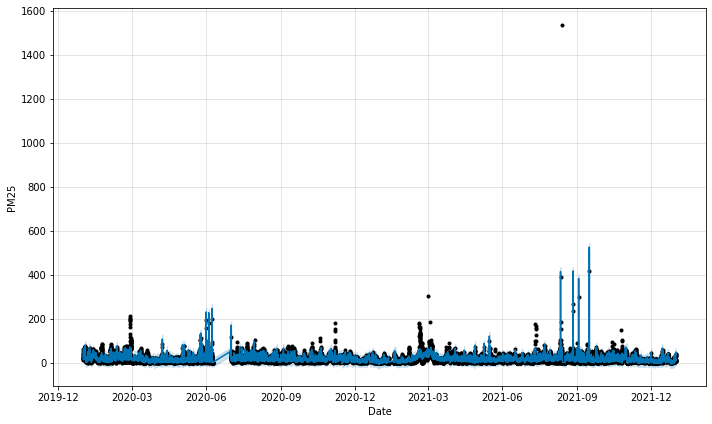

In [ ]:
# Resultado e interpretación del campo PM25
#Visualmente
plotPrediction(m_PM10,PM10_predict, "PM25")

In [ ]:
#df_cv_PM10 = getCrossValidation(m_PM10, 3*24)
df_cv_PM25 = getCrossValidation(m_PM25, 3*24)

#getCrossValidation(m_PM10, 365).head()
#getCrossValidation(m_NO2, 365).head()
#getCrossValidation(m_O3, 365).head()
#getCrossValidation(m_SO2, 365).head()

INFO:prophet:Making 238 forecasts with cutoffs between 2021-01-01 11:00:00 and 2021-12-28 23:00:00


  0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
#df_p_10 = performance_metrics(df_cv_PM10)
df_p_25 = performance_metrics(df_cv_PM25)


INFO:prophet:Skipping MAPE because y close to 0


In [ ]:
df_p_25.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 08:00:00,53.743989,7.331029,3.682670,0.348938,0.540835,0.912232
1,0 days 09:00:00,55.995198,7.482994,3.784197,0.354696,0.550521,0.906760
2,0 days 10:00:00,64.454265,8.028341,3.956417,0.352269,0.551752,0.900646
3,0 days 11:00:00,51.989579,7.210380,3.946484,0.341834,0.546552,0.894119
4,0 days 12:00:00,65.813707,8.112565,4.052642,0.335976,0.538742,0.891634


In [ ]:
categoria_train = getDFCompleto(datos_8, "Categoria")[:-72]
m_categoria = entrenar_modelo2(categoria_train, "Categoria")
categoria_test = getDFCompleto(datos_8, "Categoria")[-72:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
categoria_predict = getDatosFuturo2(m_categoria, 3, categoria_test)

                        ds  BEN  CH4   CO  y  EBE   ICA  NMHC    NO   NO2  \
101679 2022-02-26 18:00:00  0.0  NaN  0.0  0  0.0  41.0   NaN   5.0  37.0   
101680 2022-02-26 19:00:00  0.0  NaN  0.0  0  0.0  44.0   NaN   5.0  32.0   
101681 2022-02-26 20:00:00  0.0  NaN  0.0  0  0.0  42.0   NaN   6.0  35.0   
101682 2022-02-26 21:00:00  0.0  NaN  0.0  0  0.0  41.0   NaN   5.0  37.0   
101683 2022-02-26 22:00:00  0.0  NaN  0.0  0  0.0  48.0   NaN   4.0  26.0   
...                    ...  ...  ...  ... ..  ...   ...   ...   ...   ...   
101746 2022-03-30 14:00:00  0.0  NaN  0.0  1  0.0  43.0   NaN  12.0  43.0   
101747 2022-03-30 15:00:00  NaN  NaN  0.0  0  NaN  35.0   NaN   6.0  35.0   
101748 2022-03-30 16:00:00  NaN  NaN  0.0  0  NaN  33.0   NaN   6.0  33.0   
101749 2022-03-30 17:00:00  NaN  NaN  0.0  1  NaN  42.0   NaN  11.0  42.0   
101750 2022-03-30 18:00:00  NaN  NaN  0.0  0  NaN  35.0   NaN   8.0  35.0   

         NOx    O3  PM10  PM25  SO2  TCH  TOL  
101679  45.0  41.0   2.0   

KeyError: ignored

In [ ]:
PM25_predict = getDatosFuturo2(m_PM25, 3, datos_8)

In [ ]:
getMAE(PM25_train,PM25_predict,3)
getMAPE(PM25_train,PM25_predict,3)

MAE:  2.0238641711105343
MAPE:  0.4258558194928797


###Univariantes con todos los contaminantes, hacer un analisis y cuanto tiempo podemos predecir antes de que el error sea muy significativo. Siguiente paso un TCN o LSTM

In [ ]:
PM25['y'].describe()
PM10['y'].describe()
NO2['y'].describe()
O3['y'].describe()
SO2['y'].describe()

count    16776.000000
mean        18.727349
std         20.613767
min          0.000000
25%          8.000000
50%         15.000000
75%         24.000000
max       1537.000000
Name: y, dtype: float64